<a href="https://colab.research.google.com/github/DSjeongmin/Kaggle/blob/main/%5Bkaggle%5D%5BPredict_future_sales%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dataset - sales 데이터를 가지고 미래의 sales 양을 예측하는 대회
##features
 * sales_train.csv - 2013년 1월부터 2015년 10월 까지의 일일 데이터
 *test.csv - 2015년 11월에 상점과 제품의 판매량을 예측해야 한다.
 *items.csv - 품목 / 제품에 대한 정보
 *item_categories.csv - item 카테고리에 대한 정보
 *shops.csv - 상점에 대한 보충정보
 *ID - test 세트 내의 (shop과 item)에 관한 튜플을 나타내느 id
 *shop_id - 상점의 고유 식별자
 *item_id - 제품의 고유 식별자
 *item_category_id - 상품 카테고리의 고유 식별자
 *item_cnt_day - 판매된 제품 수 월별 금액을 예측할 수 있다.
 *item_price - item에 관한 가격
 *date - 해당 날짜
 *date_block_num - 편의를 위해 연속된 월 번호 / 2013년 1월은 0 2013년 2월은 2 ~ 2015년 10월은 33
 *item_name - 아이템 이름
 *shop_name - 상점 이름
 *item_category_name - 상품 카테고리 이름

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Kaggle/competitive-data-science-predict-future-sales/test.csv')
cats = pd.read_csv('/content/drive/MyDrive/Kaggle/competitive-data-science-predict-future-sales/item_categories.csv')
items = pd.read_csv('/content/drive/MyDrive/Kaggle/competitive-data-science-predict-future-sales/items.csv')
shops = pd.read_csv('/content/drive/MyDrive/Kaggle/competitive-data-science-predict-future-sales/shops.csv')
train = pd.read_csv('/content/drive/MyDrive/Kaggle/competitive-data-science-predict-future-sales/sales_train.csv')

# EDA & FE

##Outlier

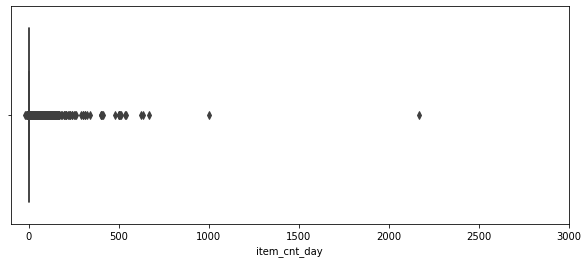

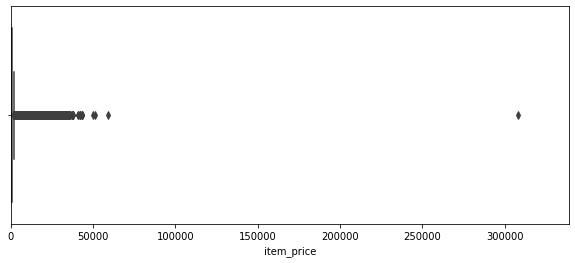

In [ ]:
plt.figure(figsize=(10,4))
plt.xlim(-100,3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [ ]:
# Boxplot 확인 결과 존재하는 이상치 제거

train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [ ]:
train = train[train.item_cnt_day >=0]
train = train[train.item_price >=0]

##Shops

In [ ]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
str(shops['shop_name'][0]).split(' ')[0]

'!Якутск'

In [ ]:
# 도시이름을 분리하여 city 컬럼에 간단히 정리
shops['city'] = shops['shop_name'].apply(lambda x: str(x).split(' ')[0])
shops.head(3)

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея


In [ ]:
# 변환된 city 컬럼 라벨 인코딩 -> shop_name 컬럼 제거
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(list(shops['city'].values))
shops['city'] = le.transform(list(shops['city'].values))

shops.drop(['shop_name'],axis=1, inplace=True)

shops.head(3)

,shop_id,city
0,0,0
1,1,0
2,2,1


##Cats

In [ ]:
cats.head(3)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


In [ ]:
# item_category 분리
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].apply(lambda x : x[0].strip())
cats.head()

,item_category_name,item_category_id,split,type
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары


In [ ]:
# type_code 인코딩, subtype 분리
cats['type_code'] = le.fit_transform(cats['type'])
cats['subtype'] = cats['split'].apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats.head(3)

,item_category_name,item_category_id,split,type,type_code,subtype
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1,PS2
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1,PS3


In [ ]:
# subtype 인코딩
cats['subtype_code'] = le.fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code','subtype_code']]
cats.head(3)

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10


##items

In [ ]:
items.drop(['item_name'],axis=1, inplace=True)

In [ ]:
len(test.shop_id.unique())

42

In [ ]:
len(set(test.item_id))

5100

In [ ]:
# 42개의 shop_id 5100개가 있으므로, 214200개의 test 데이터셋에 214200 데이터 존재
42*5100

214200

In [ ]:
# test에는 있는데 train 없는 item_id가 363개
# => 이 데이터들에 대해서는 0개가 판매된걸로 예측해야 한다.
# => 월별 판매량을 계산하고 해당 월의 고유 한 쌍마다 매출을 0으로 늘려야 할 것 같다.
len(set(test.item_id) - set(train.item_id))

363

In [ ]:
len(train.date_block_num.unique())

34

In [ ]:
# product example
np.array(list(product([1],[2,3],[5,6])), dtype='int16')

array([[1, 2, 5],
       [1, 2, 6],
       [1, 3, 5],
       [1, 3, 6]], dtype=int16)

In [ ]:
from itertools import product

matrix = []
cols = ['date_block_num','shop_id','item_id']

for i in range(34):
  sales = train[train.date_block_num==i]
  matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns = cols) # vstack 안써도 데이터프레임 값 동일
# matrix2 = pd.DataFrame(matrix, columns = cols)

matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(by=cols,inplace=True)

In [ ]:
matrix.head(3)

,date_block_num,shop_id,item_id
139168,0,0,19
141406,0,0,27
144881,0,0,28


In [ ]:
sales = train[train.date_block_num==1]
sales.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
115690,21.02.2013,1,50,3880,1499.0,1.0
115691,14.02.2013,1,50,3880,1499.0,1.0
115692,21.02.2013,1,50,4128,899.0,1.0


In [ ]:
# revenue 컬럼 = 가격 * 판매수 곱해서 만든 파생변수
train['revenue'] = train['item_price'] * train['item_cnt_day']

In [ ]:
# 세 피처에 대해 그룹바이 하여 월별 합계 추출
# 범위를 0~20으로 변경(test예측과 유사하게 만들기 위함) 
# float16타입으로 변경(Nan값 만나도 형식 변하지 않기 위함)
# matrix에 월별 판매량 merge

group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                            .fillna(0)
                            .clip(0,20)
                            .astype(np.float16))

In [ ]:
matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0


In [ ]:
train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':['count']})[('item_cnt_day', 'count')].unique()

array([ 4,  3,  1,  2, 16,  5,  6,  8,  7, 10, 15,  9, 12, 11, 14, 13, 17,
       21, 18, 20, 23, 19, 24, 22, 27, 26, 25, 29, 28, 30, 31])

In [ ]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.head(3)

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34


In [ ]:
# matrix에 테스트 데이터 merge
matrix = pd.concat([matrix, test], ignore_index = True, sort=False, keys=cols)
matrix.fillna(0, inplace=True)
matrix.drop(['ID'],axis=1, inplace=True)
matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0


In [ ]:
# 위에서 만든 city, item_category_id, type_code, subtype_code 컬럼 merge
matrix = pd.merge(matrix, shops, on=['shop_id'], how = 'left')
matrix = pd.merge(matrix, items, on=['item_id'], how = 'left')
matrix = pd.merge(matrix, cats, on = ['item_category_id'], how = 'left')
matrix['city'] = matrix['city'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city,item_category_id,type_code,subtype_code
0,0,0,19,0.0,0,40,11,4
1,0,0,27,0.0,0,19,5,10
2,0,0,28,0.0,0,30,8,55


In [ ]:
def lag_feature(df, lags, col):

  tmp = df[['date_block_num','shop_id','item_id',col]]
  for i in lags:
      shifted = tmp.copy()
      shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
      shifted['date_block_num'] += i
      df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
  return df

In [ ]:
# item_cnt_month_lag_i 는 i달전의 동일 shop, 동일 제품의 판매량

# 1,2,3,6,12달 전의 동일 shop, 동일 제품의 판매량
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,0,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN


In [ ]:
# matrix에 월 평균 판매 수량 컬럼 추가

# item_cnt_month_lag_1는 1,2,3,6,12달 전의 동일 shop, 동일 판매량 뜻한다.
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1
0,0,0,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# matrix에 월별 item별 평균 판매 수량인 date_item_avg_item_cnt lag 추가
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
# matrix에 월별 shop_id별 평균 판매 수량인 date_shop_avg_item_cnt lag 추가
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
# matrix에 월별 item_category_id별 평균 판매 수량인 date_cat_avg_item_cnt lag 추가
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1
0,0,0,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# matrix에 월별 shop_id,item_category_id별 평균 판매 수량인 date_shop_cat_avg_item_cnt lag 추가

group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
# matrix에 월별 shop_id, type_code별 평균 판매 수량인 date_shop_type_avg_item_cnt lag 추가

group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
# matrix에 월별 shop_id, subtype_code별 평균 판매 수량인 date_shop_subtype_avg_item_cnt lag 추가

group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
# matrix에 월별 city별 평균 판매 수량인 date_city_avg_item_cnt lag 추가
group = matrix.groupby(['date_block_num','city']).agg({'item_cnt_month' : ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','city'],how='left')
matrix['date_city_avg_item_cnt']=matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
# matrix에 월별 item_id, city별 평균 판매 수량인 date_item_city_avg_item_cnt lag 추가
group = matrix.groupby(['date_block_num','item_id','city']).agg({'item_cnt_month':['mean']})
group.columns = ['date_item_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on = ['date_block_num','item_id','city'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1
0,0,0,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# matrix에 월별 type_code별 평균 판매 수량인 date_type_avg_item_cnt lag 추가
group = matrix.groupby(['date_block_num','type_code']).agg({'item_cnt_month':['mean']})
group.columns = ['date_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'],axis=1, inplace=True)

matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1
0,0,0,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# matrix에 월별 subtype_code별 평균 판매 수량인 date_subtype_avg_item_cnt lag 추가
group = matrix.groupby(['date_block_num','subtype_code']).agg({'item_cnt_month':['mean']})
group.columns = ['date_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,0,0,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# lags를 1,2,3,4,5,6을 주어 지난 6개월간 변동 추세 확인

# item_Id 별 / 월별, item_id별 평균 가격을 추가한 뒤에 
# 평균 가격이 어떠한 추세를 보이는지 delta_pricelag을 구함.

group = train.groupby(['item_id']).agg({'item_price':['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price':['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on = ['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
    (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]

features_to_drop = ['item_avg_item_price','date_item_avg_item_price']
for i in lags:
    features_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    features_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(features_to_drop,axis=1, inplace=True)

In [ ]:
# delta_revenue 변수를 만들어서 shop_revenue 추세를 파악

group = train.groupby(['date_block_num','shop_id']).agg({'revenue':['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'],how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue':['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on = ['shop_id'],how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue']-matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delat_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'],axis=1,inplace=True)

In [ ]:
# matrix에 월별 변수를 만들어 준다.
matrix['month'] = matrix['date_block_num'] % 12

In [ ]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [ ]:
# 키가 {shop_id,item_id}이고 값이 date_block_num과 같은 해시 테이블을 생성합니다. 
# 데이터를 처음부터 반복합니다. 
# 각 행에 대해 {row일 경우.shop_id, row.item_id}이(가) 
# 테이블에 없는 경우 테이블에 추가한 다음 값을 row.date_block_num으로 설정합니다. 
# 해시 테이블에 키가 포함되어 있으면 캐시된 값과 row.date_block_num 사이의 차이를 계산하십시오.

cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        # at은 행 명과 열 명으로 위치를 지정한다. 데이터를 획득하기 위할 뿐만 아니라, 
        # 그 위치에 새로운 값을 설정(대입)하는 것도 가능
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num    

In [ ]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num  

In [ ]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

# lag를 12까지 사용했으므로 처음 12달 드랍
matrix = matrix[matrix.date_block_num > 11]


In [ ]:
# 결측치에 0 대입
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [ ]:
# 데이터 저장
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

In [ ]:
# 데이터 불러오기
import pandas as pd
data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Kaggle/data.pkl')
data.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delat_revenue,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4478844,12,2,27,0.0,1,19,5,10,0.0,0.0,0.0,0.0,1.0,0.412109,0.086975,0.044434,0.130493,0.065247,0.155518,0.14856,0.10083,0.089355,0.096252,0.141968,1.084961,0.962402,0.811523,0.943359,0.14856,0.0,1.038086,1.078125,-0.282715,-0.191406,1.210315,0,31,1,1,12,12
4478845,12,2,30,0.0,1,40,11,4,0.0,0.0,0.0,0.0,0.0,0.412109,1.021484,1.022461,0.521973,0.891113,0.000000,0.14856,0.10083,0.089355,0.096252,0.000000,0.291748,0.046234,0.051727,0.046234,0.14856,0.0,0.270264,0.291748,-0.482910,-0.191406,1.210315,0,31,1,1,11,11
4478846,12,2,31,0.0,1,37,11,1,0.0,0.0,0.0,0.0,0.0,0.412109,0.543457,0.600098,0.543457,0.304443,0.000000,0.14856,0.10083,0.089355,0.096252,0.000000,0.233398,0.059448,0.051727,0.064697,0.14856,0.0,0.270264,0.234741,-0.137451,-0.191406,1.210315,0,31,1,1,11,11


In [ ]:
# 완벽한 컬럼만 추출
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [ ]:
data.head()

,date_block_num,shop_id,item_id,item_cnt_month,city,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4478844,12,2,27,0.0,1,19,5,10,0.0,0.0,0.0,0.0,1.0,0.412109,0.086975,0.044434,0.130493,0.065247,0.155518,0.14856,0.10083,0.089355,0.096252,0.141968,1.084961,0.962402,0.14856,0.0,-0.282715,0,31,1,1,12,12
4478845,12,2,30,0.0,1,40,11,4,0.0,0.0,0.0,0.0,0.0,0.412109,1.021484,1.022461,0.521973,0.891113,0.000000,0.14856,0.10083,0.089355,0.096252,0.000000,0.291748,0.046234,0.14856,0.0,-0.482910,0,31,1,1,11,11
4478846,12,2,31,0.0,1,37,11,1,0.0,0.0,0.0,0.0,0.0,0.412109,0.543457,0.600098,0.543457,0.304443,0.000000,0.14856,0.10083,0.089355,0.096252,0.000000,0.233398,0.059448,0.14856,0.0,-0.137451,0,31,1,1,11,11
4478847,12,2,32,1.0,1,40,11,4,0.0,0.0,0.0,0.0,0.0,0.412109,1.956055,1.799805,1.260742,1.891602,5.378906,0.14856,0.10083,0.089355,0.096252,0.141968,0.291748,0.046234,0.14856,0.0,-0.407471,0,31,-1,1,12,12
4478848,12,2,33,1.0,1,37,11,1,1.0,2.0,0.0,0.0,1.0,0.412109,0.913086,0.333252,0.717285,1.000000,1.355469,0.14856,0.10083,0.089355,0.096252,0.141968,0.233398,0.059448,0.14856,1.0,-0.224976,0,31,1,1,12,12


##Modeling

In [ ]:
# date_block_num이 
# 34month 인경우 test데이터로 
# 33month인 경우에는 검증데이터로
# 13~33month는 train 데이터로 사용


X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
import gc
del data
gc.collect();

In [ ]:
from xgboost import XGBRegressor
from xgboost import plot_importance

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[09:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:29:55] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.15368	validation_1-rmse:1.11756
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10616	validation_1-rmse:1.08047
[2]	validation_0-rmse:1.06931	validation_1-rmse:1.05387
[3]	validation_0-rmse:1.03637	validation_1-rmse:1.02993
[4]	validation_0-rmse:1.00677	validation_1-rmse:1.008
[5]	validation_0-rmse:0.982149	validation_1-rmse:0.990631
[6]	validation_0-rmse:0.961122	validation_1-rmse:0.977069
[7]	validation_0-rmse:0.94376	validation_1-rmse:0.965894
[8]	validation_0-rmse:0.928202	validation_1-rmse:

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=300, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=1)

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))